In [1]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Operator, DensityMatrix, ScalarOp
from qiskit.circuit.library import Diagonal
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [2]:
def init(circuit, qubits):
    for q in qubits:
        circuit.h(q)
    return circuit

oracle = QuantumCircuit(5, name='oracle')
qubits = [0, 1, 2, 3, 4]
possible_comb = ['10001','11011','11001','11110','11000'] 
mark_circuit = []
mark_comb = []

for i in range(len(possible_comb)):
    mark_comb.append(Statevector.from_label(possible_comb[i])) # Diagonal operator for mark
    mark_circuit.append(Diagonal((-1)**mark_comb[i].data))  # Circuit that induces a -1 phase on the marked states
    oracle.append(mark_circuit[i], qubits)

oracle.draw()

┌───────────┐┌───────────┐┌───────────┐┌───────────┐┌───────────┐
q_0: ┤0          ├┤0          ├┤0          ├┤0          ├┤0          ├
     │           ││           ││           ││           ││           │
q_1: ┤1          ├┤1          ├┤1          ├┤1          ├┤1          ├
     │           ││           ││           ││           ││           │
q_2: ┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├
     │           ││           ││           ││           ││           │
q_3: ┤3          ├┤3          ├┤3          ├┤3          ├┤3          ├
     │           ││           ││           ││           ││           │
q_4: ┤4          ├┤4          ├┤4          ├┤4          ├┤4          ├
     └───────────┘└───────────┘└───────────┘└───────────┘└───────────┘

In [3]:
def diffuser(qubits):
    amp = QuantumCircuit(5, name='amplifier')
    amp.h(qubits)
    amp.x(qubits)
    inv = Statevector.from_label('11111')
    inv = Diagonal((-1)**inv.data)
    amp.append(inv, qubits)
    amp.x(qubits)
    amp.h(qubits)
    return amp

amp = diffuser(qubits)
amp.draw()

┌───┐┌───┐┌───────────┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤0          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_1: ┤ H ├┤ X ├┤1          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_2: ┤ H ├┤ X ├┤2 Diagonal ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_3: ┤ H ├┤ X ├┤3          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_4: ┤ H ├┤ X ├┤4          ├┤ X ├┤ H ├
     └───┘└───┘└───────────┘└───┘└───┘

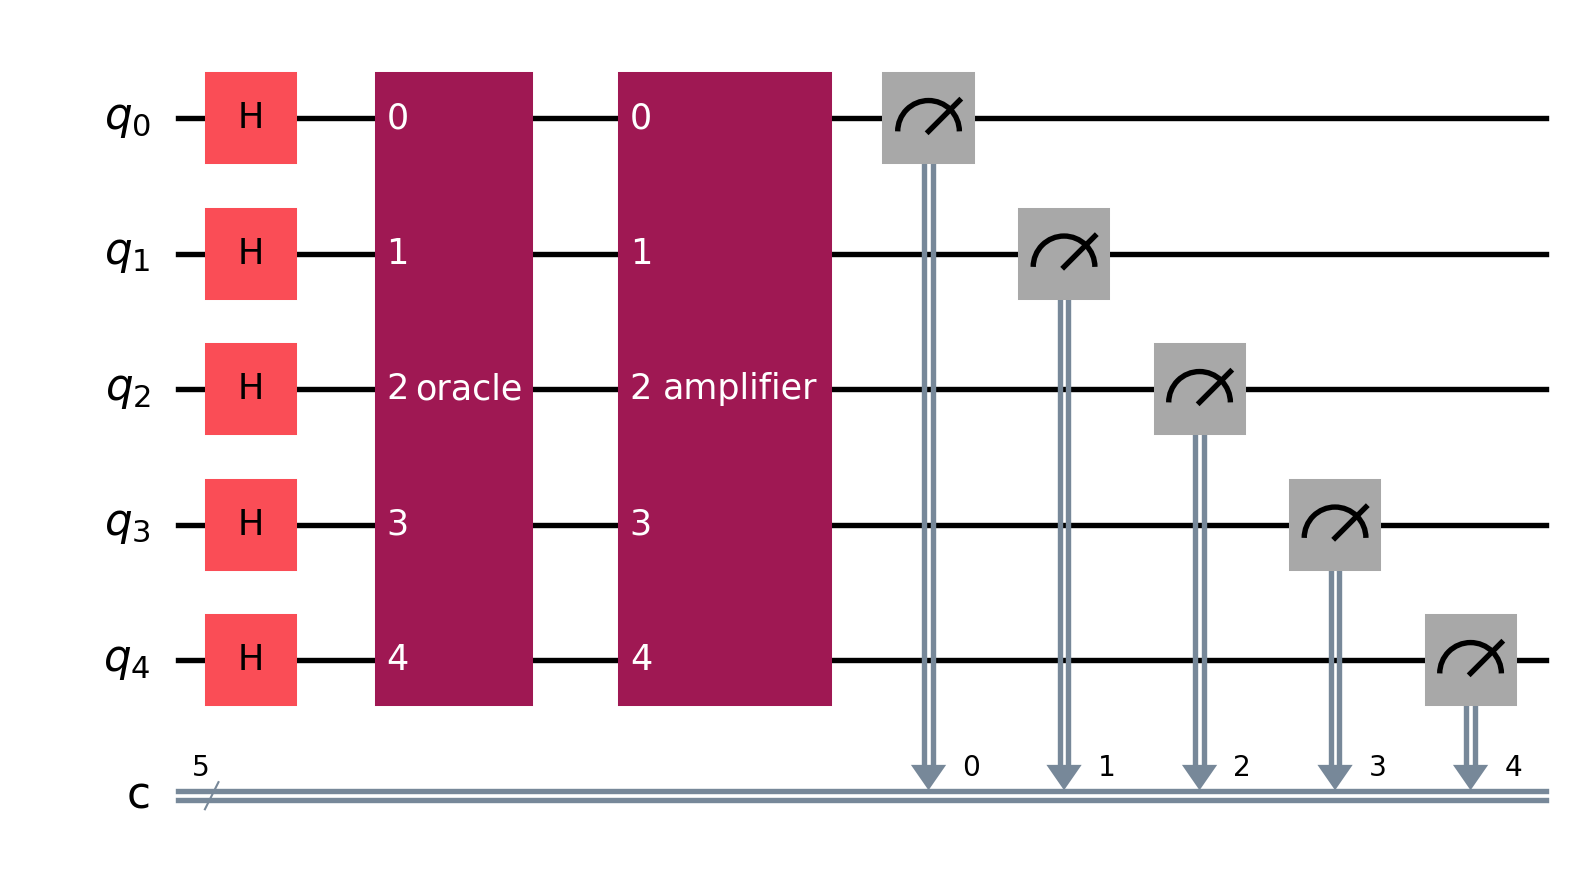

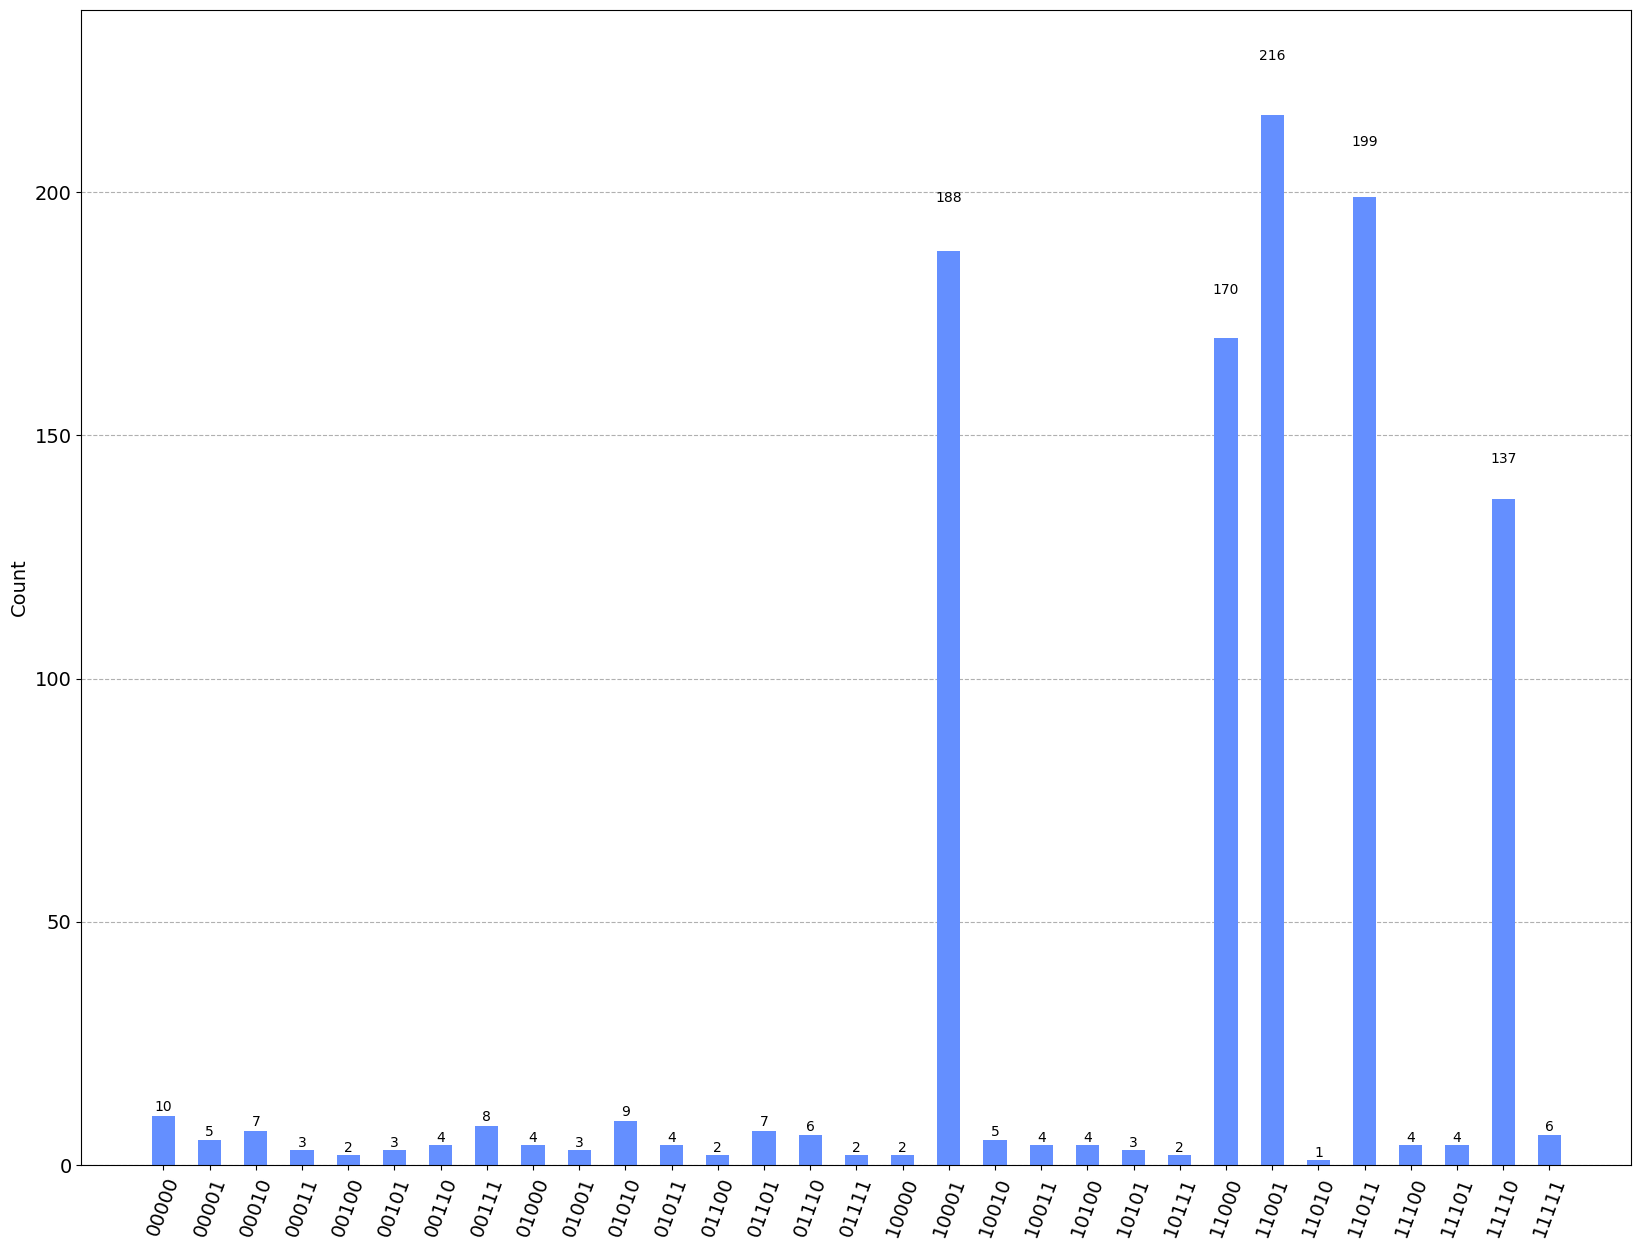

In [7]:
gc = QuantumCircuit(5, 5)
gc = init(gc, qubits)
gc.append(oracle, qubits)
gc.append(amp, qubits)

qasm_sim = Aer.get_backend('qasm_simulator')
gc.measure(qubits, qubits)
fig = plt.figure(figsize=(20,15))
gc.draw(output='mpl', ax=fig.gca())  # Final circuit (Image type file)

job_sim = qasm_sim.run(transpile(gc, qasm_sim), shots=1024)
res = job_sim.result()
fig2 = plt.figure(figsize=(20,15))
plot_histogram(res.get_counts(gc) ,ax=fig2.gca())